## Table of Contents
1. [Preliminaries](#prelim)

 1.1 [Introduction](#introduction)
 
 1.2 [Classification in Economics](#classification)
 
 1.3 [CART](#cart)
 
 1.4 [CRAGGING](#cragging)
 
 
2. [Decision Trees](#decision)


3. [CRAGGING Estimator](#cragg_estimator)


4. [Conclusion](#conclusion)

### Remark: Required Package
In order to properly display the decision trees in this notebook, you should install the _graphviz_-package on your machine, as it will be required to display the decision trees in this notebook. 
The commands are the following: 

   **Linux** (Ubuntu): 
~~~~
sudo apt-get install graphviz
~~~~
   **Mac**: 
~~~~
ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
brew install graphviz
~~~~
**Windows** (Anaconda Prompt): 
~~~~
conda install -c anaconda graphviz
~~~~


<a name="prelim"></a>
## Preliminaries

<a name="introduction"></a>
#### Introduction

In this Notebook, we develop a function that implements a particular classification algorithm: CRAGGING, which stands for **CR**oss-validation **AGG**regat**ING**. CRAGGING was developed as a refined generalizaton  of the traditional classification and regression tree (CART). CRAGGING was shown to perform better when the data has a panel structure – which CART does not take into account at all – and might therefore be of interest to researchers who want to make use of the traditional benefits of CART, but applied in the context of  panel data.  In particular, compared to CART the algorithm is  
 * robuster to small changes in the data, 
 * achieves better out-of-sample predictions and 
 * produces fewer type-II errors. 

We   illustrate the use of the algorithm by partly replicating a particular problem,  which this notebook is based on: Classifying and predicting sovereign defaults across countries and years. (*See [Savona & Vezzoli (2013)](https://onlinelibrary.wiley.com/doi/abs/10.1111/obes.12052) for the original paper.*) This problem is quite intensively studied in the literature, because policymakers would derive obvious benefits from having an  "early-warning-system" (EWS) that can strike a sound balance between producing accurate  forecasts of future defaults (*out-of-sample prediction*) while at the same time being able to eluminate the drivers of its results (*interpretability*) – after all, policymakers need to be able to communicate the rationale behind their recommendations to non-experts.  (*See [here](https://books.google.ch/books?hl=en&lr=&id=ZrO-sFjDceoC&oi=fnd&pg=PA3&dq=manasse+roubini&ots=RhmCUJpihw&sig=TM6_Ydz1nE9rdXqwNR2qDR58FWU#v=onepage&q=manasse%20roubini&f=false), [here](https://www.sciencedirect.com/science/article/pii/S0022199609000440), [here](https://link.springer.com/article/10.2307/30035972) and [here](https://www.sciencedirect.com/science/article/pii/S0167947306002842) for a few of many, many such papers.*) 

For our purposes, this  example is interesting because: 
 * The relationship between  default and observable economic quantities has a  highly non-linear structure. For example, a liquidity crises might have patterns in the covariates that look very different from the case of a solvency crisis.  
 * Given that sovereign defaults usually concern developing countries, the data has many missing values and extreme outliers.
 * There are as many predictors to choose from as there are country-level variables – including their transformations – which is a lot. Therefore, we need to be able to select relevant variables without much discretion. 
 * The prediction system needs to be easily understood by experts and non-experts alike. 
 * The data has a panel structure, so that methods devised for cross-sectional data will not make use of all the information contained in the data. 

As we will see,   CART fulfills most of these needs. CRAGGING, which essentially creates a CART based on the average predictions obtained from  an ensemble of CARTs that were estimated based on rotating subsamples of the data, is better still. Logit, while also often used, underperforms in this specific  task.   

Before turning to the code and the example, however, we discuss the underlying concepts – classification in economics, CART and CRAGGING – in some more detail.  

<a name="classification"></a>
#### Classification in economics

(*A highly readable discussion that touches on some of the points elaborated on in the following section is also contained in [Varian (2014)](https://www.aeaweb.org/articles?id=10.1257/jep.28.2.3)*)

When doing empirical research in economics – and, of course, in many other disciplines as well – one will sooner or later be confronted with the problem of *classification*. In the canonical problem of classification, we study   a data set $(Y, \mathbf{X}$), where $Y$ is a $n \times 1$  vector of a categorical *dependent* variable, and $\mathbf{X}$ is a $n \times p$ matrix consisting of the corresponding covariates, or *features*. The problem that we are  usually  interested in solving is either (1) to *predict* to what category some observation most likely belongs to, given its set of features, or (2) to *infer* the causal impact of a  particular feature on  the probability of belonging to a group for the "average" observation. A standard textbook example from economics, for example, is that of explaining female labour force participation (*"in- or outside the labour market?"*) as a function of such variables as age, education, the  spouse's income and the number of young children. While in a pure prediction version of this problem we would simply want to find the best way to tell whether a particular woman is working, given her circumstances, in an inference problem we might be interested in  finding out whether an increase in the number of children *causes* a change in the likelihood of working. (This particular example is sourced from [Wooldridge (2010, pp. 563)](https://mitpress.mit.edu/books/econometric-analysis-cross-section-and-panel-data-second-edition)). 

Given the ubiquity of such classification problems in economics, it does not surprise that econometrics possesses  a well established machinery to tackle them. If $Y$ is binary, i.e. $Y \in \{0,1\}$, the conventional approach is that of  a *logit model* (or, alternatively, a probit model), which postulates the existence of a particular functional relationship between the dependent variable and the features: $$Y = G(\mathbf{X \beta}) = \frac{\exp{(\mathbf{X \beta})}}{1+\exp{(\mathbf{X \beta})}}$$ where $\beta$ is a $p \times 1$ vector of parameters that is  estimated from the data, usually by maximum likelihood. Note that this particular  function constrains $Y$ to be between $0$ and $1$, so that the estimates derived from the model can  directly be interpreted as probabilities. A particular observation $(y,\mathbf{x})$ is then predicted to belong to the 1-group if $\hat{y} := G(\mathbf{x \hat{\beta}}) \geq 0.5$, and to the 0-group otherwise.  

This set-up has the benefit of yielding parameter estimates that are at least somewhat interpretable, so that we might deduce the relative importance of various features in explaining the dependent variable as well as their statistical significance. This is different from more flexible models, such as neural networks, which do not put such rigid constraints on the functional relationship between $Y$ and $\mathbf{X}$ and are therefore often better in describing the data, but at the cost of essentially being inscrutable "black-boxes". (*This conflict is known as the trade-off between prediction accuracy and model interpretability, better described in chapter 2 of [James et al. (2013)](https://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf)*.)    Given that economists put a lot of value on   interpretability, for interpretability is needed in order to give insights into underlying economic relationships and to do causal inference, logit has become the default approach to classifiation problems in economics. 

<a name="cart"></a>
#### Alternative: CART
  
Of course, a method being the default option does not make  it the best method for  all possible purposes. As we have seen, for example, logit imposes a very particular functional relationship that might not be a good description of the data at all. In particular, note that $$ \mathbf{X \beta} = \sum_{j=1}^p \beta_j \mathbf{x}_j $$ assumes that the regressors enter the model linearly in the parameters. As a consequence, any given variable will  have a uniform impact on the outcome. This issue might be circumvented by including squared regressors, but if this produces a turning point from which onwards the sign of the effect changes, the impact will still follow a very smooth curve over the support. However, this need not be true in reality: In the case of sovereign defaults, for example, it might be the case that some variables exert influences that vary a lot in their sign and strength, conditional on the covariates (which might signify different archetypes of crises). If we knew beforehand which variables this applies to, we might be able to capture such  effects in a logit model by including many interaction terms in the model, but this is a big "if".  Therefore, it can be preferrable to work with a more flexible model from the beginning, especially if the problem relates more to prediction than causal inference.  

Classification trees offer  exactly such flexibility, while retaining a high degree of interpretability. As the name implies, a classification tree can be understood as a decision tree, on each node of which the data is split according the value of a particular covariate. To give a more precise definition:  
> A classification or regression tree (CART) is a **binary recursive partition of the feature space** into various disjoint regions (or *terminal nodes*), where each region is assigned a constant predicted value for the dependent variable (usually the mean of all observations that lie in that region.) 

(*Note: The feature space is essentially the Cartesian product of the  sets the various regressors are defined on*.) 

This partition of the feature space is completely non-parametric and is done with the goal of achieving maximal homogeneity within the different regions, albeit in a "greedy" manner. That is, because it would be computationally  unfeasible to evaluate *all* possible ways the feature space could be partitioned in order to choose the best one, splits are chosen sequentially such that they minimize the loss from misclassification only one step ahead. 


Such trees can be grown until some stopping rule applies, such as a maximal number of terminal leaves, and then be "pruned" or reduced by imposing a cost on their complexity. The technical details behind CART should become clearer when we program a particular example in Python. 

At this point, we rather wish to give some indication of their benefits that can justify their use: 

 * Trees are even easier to interpret than regression models
 * Outcomes are robust to the presence of individual outliers
 * They tend to work well for problems where there are important non-linearities and interactions present and allows users to discover such patterns 
 * No specification search is necessary and the results remain the same under monotonic transformations of the variables
 * Can also be used when data in the covariates is missing 
 * When there are many potential predictors, trees can be useful as a screening device that selects the most relevant variables and interactions for further analysis
 *  Regression trees tend to be better for larger data sets in terms of prediction, although logit outperforms for smaller data sets [(Perlich, Provost and Simonoff, 2003)](http://www.jmlr.org/papers/volume4/perlich03a/perlich03a.pdf)

There are many situations in economics where these benefits could be useful, and CART is in fact used from time to time. For example, [Alessi & Detken (2018)](https://www.sciencedirect.com/science/article/pii/S1572308917304291) use an ensemble of regression trees (or *random forest*) to develop an EWS of unsustainable credit growth, [Ghosh & Ghosh (2002)](https://www.imf.org/external/pubs/ft/wp/2002/wp0209.pdf) study currency crises and [Manasse & Roubini (2009)](https://www.sciencedirect.com/science/article/pii/S0022199609000440) develop a CART-based EWS for sovereign default.

Of course, these benefits are bought at some cost. In particular: 

 * Trees tends to underperform when the underlying relationship is indeed linear.
 * Because the procedure is non-parametric, one cannot attach confidence intervals on the thresholds (although one can  test the thresholds by incorporating them as dummies in a logit model).
 * If two variables are closely related, one might never appear in the tree even if its more „important“ in explaining the variance in the dependent variable than other regressors that do appear. This might lead to  specious conclusions. (*This phenomenon is called „masking“, which is analogous to the concept of multicollinearity in regression models.)*
 * Trees are sensitive to changes in the data sample and the regressors, which makes them rather unstable. 
 * It is not possible to deduce marginal effects from the tree.
 * Trees tend to underperform other models for pure prediction purposes.

<a name="cragging"></a>
#### CRAGGING

CRAGGING is designed to improve on some – though not all – of these disadvantages. In particular, it deals with the issues of tree instability and out-of-sample prediction performance. In addition, while trees are traditionally designed for cross-sectional data, which assumes that observations are IID, the CRAGGING algorithm was explicitly designed with panel data in mind. This can make it an alternative to boosting or random forests, which are other popular methods to improve the predictive powers of trees, when the data is in panel format. 

In essence, how CRAGGING works is that it repeatedly estimates CARTs on rotating  subsets of the data and  uses the average from the predictions so produced as the  dependent variable in a final tree. A more detailed description, of which a graphic illustration can be found [here (university access required)](https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2Fobes.12052&file=obes12052-sup-0002-AppendixS2.pdf), is the following: 

 1. *Assume a (balanced) panel data set $(Y, \mathbf{X}$),  consisting of $J$ units, each with $T$ time periods.*
 2. *Randomly split the data set into $V$  subsets such that (1) the subsets are as close to equally sized as possible (2) no data for any unit is contained in more than one subset, which implies $V < J$.*
 3. *Choose  a subset $\mathcal{L}_v$ to be put aside a test set.* 
 4. *Create a new set $\mathcal{L}$ as the union of the remaining $V-1$ subsets. $\mathcal{L}$ contains $J_v := \frac{J}{V-1}$ units.*
 5. *Reduce $\mathcal{L}$ by removing all observations belonging to a particular unit of observation. Call the new set $\mathcal{L}^R$, which is a "perturbed" training set.*
 6. *Train a CART on $\mathcal{L}^R$, which includes its pruning using a fixed complexity cost parameter $\alpha \geq 0$.*
 7. *Compute and store the predictions for the test set that are obtained from the tree.*
 8. *Create a new set $\mathcal{L}^R$ by removing all observations belonging to another   unit of observation from $\mathcal{L}$.* 
 9. *Repeat steps 5. to 8., in each iteration exlcuding a unit of observation from $\mathcal{L}$ that has not been removed so far.*
 10. *Repeat step 9. until every unit of observation was excluded once from $\mathcal{L}$. At the end of this step,  we have $J_v$ predictions for the test set.*
 11. *Average these predictions to obtain a final prediction for the test set data.*
 12. *Repeate steps 3. to 11. with different subsets as test set, so that every subset was exactly once a test set. At the end of this step, we will have predicted averages for all observations in the data set.*
 13. *Repeat steps 2. – 12. $M$ times in order to obtain $M$ predictions for all observations.* 
 14. *Average the $M$ predictions in order to obtain your final predictions.*
 15. *Grow a final regression tree (FRT) for which the binary dependent variable is replaced by the predictions obtained in step 14.*
 
This is  an elaborate procedure that is computationally quite intensive. For example, given 50 units that are split into 10 subsets, the algorithm will grow $10 \cdot 40 = 400$ trees in a single iteration (For each of the $10$ subsets, it grows as many trees as there are units in the training set, $40$). For $M = 50$, i.e. $50$ iterations, this results in $20'000$ classification trees, which adds up to $20'001$ regression and classification trees when including the final one. 

This begs the question, what is the point of doing this? What [Savona & Vezzoli (2013)](https://onlinelibrary.wiley.com/doi/abs/10.1111/obes.12052) argue from theory and demonstrate empirically is that there are several advantages to this procedure:
* The point of the forecast averaging in steps 13–14 as well as step 11 is to reduce the overall generalization error of the model, which has been shown to converge to a limiting value as $M$ increases. 
 * The point of step 15 is to mitigate the effect of noisy data in both  the dependent and independent variables on the estimation. Also, it incorporates the forecasting ability of multiple trees. 
 
 
In the end, this procedure is supposed yield a parsimonious model with *"good predictability (accuracy), better interpretability, and minimal instability."*


<a name="decision"></a>
## Decision Trees
As touched upon in the introduction, in economics we often encounter classification problems to explain and predict economic phenomena. For example if a country was situated in a region rich with natural resources (e.g. oil under the shores) one would come to say it _classifies_ as an exporting country. When looking at the data countries with such resources more often than not have quite large export shares of GDP (meaning a lot of their income comes from such exports.) This is a very specific classification problem where we look at whether somebody is an net exporter (exports more than he imports) or a net importer (more imports than exports). 

When looking at more than two factors that determine a class we have to solve more complex classification problems. We can do that by setting up a decision tree in which we classify objects, which is a braod definition of anything that needs to be classified such as countries, persons, firms or cars. 

We will work through the mechanisms of a decision tree by examining a dataset on survivors of the titanic. 
For each passenger we know 4 criteria, their sex, age, class and fare. 
We will therefore first create a decision tree with [scikit](https://scikit-learn.org/stable/modules/tree.html) and then look at the structure. 

/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


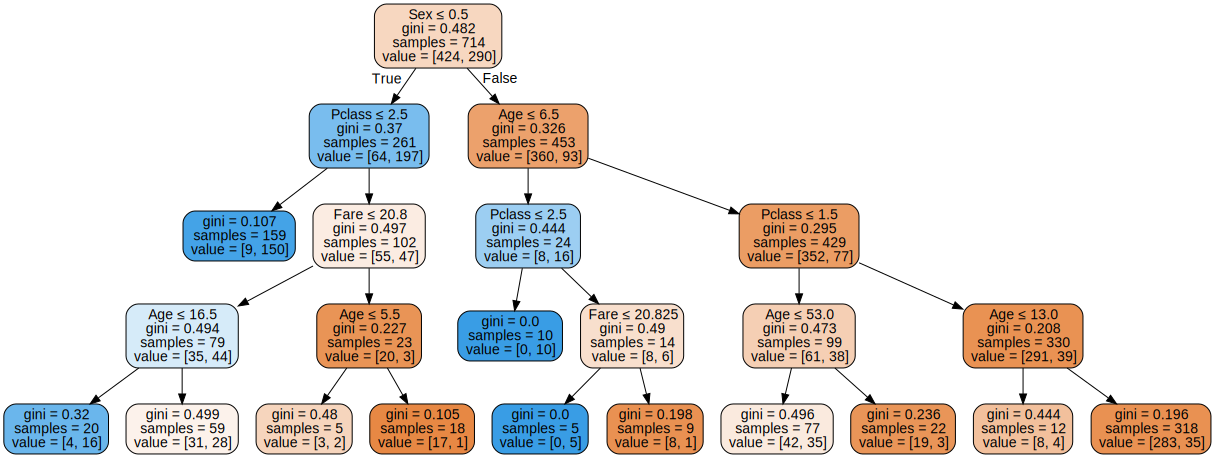

In [32]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn import tree
import sklearn
from sklearn.externals.six import StringIO  
import graphviz


data = pd.read_csv('train.csv', usecols = [1,2,4,5,9])
data = data.dropna(axis = 'index', how = 'any')
predictors = data[['Pclass', 'Sex', 'Age', 'Fare']]
outcomes = data['Survived']
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 4, min_impurity_decrease = 0, min_impurity_split = 0.2)
clf = clf.fit(predictors,outcomes)

data = sklearn.tree.export_graphviz(clf,out_file=None, filled=True, rounded=True, 
                                    feature_names=['Pclass', 'Sex', 'Age', 'Fare'], special_characters=True)
graph = graphviz.Source(data)
graph


The above graphic shows how the dataset has been split and ultimately assigned groups of which some are more likely to survive and some less. The interesting part behind this system is the question of how the tree decides to group.
Let's start at the beginning. The tree needs to to split some attribute at some level (cut-off). 
To measure which splits (and cut-offs) are more useful in order to classify more accurately we use the gini coefficient. 

The partial coefficient measures how separated, thus well split, the two groups are that resulted from the split. 
$$g_{p} = 1-\Big(\frac{\text{Survivors in Group}}{\text{Total People in Group}}\Big)^2-\Big(\frac{\text{Deceased in Group}}{\text{Total People in Group}}\Big)^2$$ # some more words on how to interpret that.
After having calculated the two separate gini-coefficients for the respective groups, we can combine them to calculate a total gini coefficient, which measures the effectiveness of that split regarding the separation of groups (survivors, $A$ and deceased, $B$).
$$\text{total gini} = \Big(\frac{\text{# People in Group A}}{\text{# People in Both Groups}}\Big)*g_{p, A}+\Big(\frac{\text{# People in Group B}}{\text{# People in Both Groups}}\Big)*g_{p,B}$$

Notice that if group A (B) contains all survivors (deceased), the total gini_coefficient is 0 as $g_{p,A}=g_{p,B}=0, which implies that the total gini coefficient is zero as well. 
Thus, the lower the partial gini coefficient, the more useful the split at that specific cut-off. 

This mechanism is used throughout the tree, regardless of it's depth and width. At each split, every criteria and several cut-offs are tested and compared, of which the one with the lowest total gini coefficient will be used. This process can be continued until we have perfect separation (pure leafs) as the final nodes of our tree or until we have 'pure enough' leafs. 

Now that we have understood how a decision tree is created and can understand the underlying decisions we will now go over to implement the earlier mentionned CRAGGING algorithm that is a little more complex decision tree and thus yields even better results as overfitting and underfitting tendencies are reduced by using not only one but multiple trees to classify. 

<a name="cragg_estimator"></a>
## CRAGGING estimator
In the following, we implement the CRAGGING estimator. Our strategy will be to create a `class` object and endow it with various methods that we will need in order to compute the final tree. In passing, we also offer some additional functionality that might be useful to a user. For example, we will define a method that reshapes a traditional 'flat' panel data set, as it is commonly encountered in applications like Stata or Excel, into a `Multiindex` pandas data frame.  

One note before we explain the algorithm, however: For parsimoniousness, we reproduced it in a slightly altered fashion compared to the original description. When we grow the trees, instead of coding them from the bottom up we  made use of the `sklearn` module, which is widely used for statistical learning tasks in Python. However, the regression and classification trees by `sklearn` currently do not allow us to control the size of the tree via the cost of the complexity parameter $\alpha$, which is used in the original algorithm. Instead, we have to work with a given maximum number of leaves, which is a somewhat less optimized method.  

In the following, we will explain the different  blocks one by one. We will put them all together in the end. Therefore, there is no need to run the cells (and in fact, it would not work!). 


In [33]:
import os
import pandas as pd
import random 
import numpy as np
from sklearn import tree
import sklearn
from sklearn.externals.six import StringIO  
from sklearn.metrics import mean_absolute_error
import graphviz

class cragging:
    
    def __init__(self, df, unit, time, dependent, n, categorical = None):
        if categorical is None:
            categorical = unit    
        self.df = df
        self.unit = unit
        self.time = time
        self.dependent = dependent
        self.n = n
        self.categorical = categorical
        self.unit_list = list(self.df[self.unit].unique())
        self.predictor_list = [x for j,x in enumerate(list(df)) if j not in [df.columns.get_loc(dependent), 
                               df.columns.get_loc(unit), df.columns.get_loc(time)] + [df.columns.get_loc(categorical)]]

We begin by initalizing the class. 
* `df`refers to the dataframe that the user wishes to analyse. It is assumed to be a flat panel data set, converted to a standard pandas dataframe.
* `unit` is the column that contains the identifiers for the panel units (e.g the country names in a country-level panel set), as a string.
* `time` is the column that contains the time dimension, as a string.
* `dependent`identifies the column that contains the dependent variable, as a string.
* `n`is the number of subsets the data set should be split into, i.e. $V$ in the algorithm description above.
* `categorical` contains any columns, apart from `unit`and `time`, that should be excluded as a predictor, as a string. It is called "categorical" because it will typically be a column containing a categorical variable that should be converted to a set of dummy variables beforehand. 

The attributes should be relatively clear, apart from the following:

* `self.unit_list` contains a list of all unique panel units, as strings.
* `self.predictor_list`contains a list of all predictor variables, as strings. We define the predictor list as all columns except the unit, time, dependent and categorical column. 

Next, we define the methods. We start with some auxiliary ones that we will need later on.

In [34]:
 def reshape(self, form): 
    self.df[self.time] = pd.to_datetime(self.df[self.time].astype("int"), format = form)
    self.df.set_index([self.unit, self.time], inplace=True)
    return self.df   

This function reshapes a dataframe, that has a format such as `df`, and converts it into a `Multiindex`  dataframe. This type of data frame is the preferred method of working with panel data sets in Python, as it allows us to represent three (and potentially higher) dimensional data as flat tables. *(In fact, the name pandas is even derived from the word panel data.)* 

In [35]:
 def partition(self): 
    aux_lst = random.sample(self.unit_list, k=len(self.unit_list))
    division = len(self.unit_list) / float(self.n) 
    return [ aux_lst[int(round(division * i)): int(round(division * (i + 1)))] for i in range(self.n) ]
    
def add_dummies(self): 
    return pd.get_dummies(self.df)
    
def dropna(self):
    return self.df.dropna(how = "any", axis = 0)
    
def lag_cols(self, to_lag, lags): 
    aux_df = self.df.groupby(level=0)[to_lag].shift(-lags)
    self.df = self.df.drop(columns=to_lag)
    return pd.merge(self.df, aux_df, left_index=True, right_index=True, how='outer') 

The `partition` function is the most interesting of these methods. In essence, given an arbitrary list, it will generate a collection of `n` random, roughly equally sized subsets of that list, and store it in a list of lists. We will need this later on when we have to randomly partition the data set into subsets to put one aside for testing. In our case, we will do this by inputting the `self.unit_list`, which will give us a random split of the panel unit names, through which we can then generate the corresponding sets. 

The other methods transfer some basic functionality from dataframes that we need to our own class. For example, through the `add_dummies` method we can transform all categorical variables into 0-1 variables that can actually be made use of in the analysis. The `lag_cols` method takes a list of column names as input and lags these columns – taking the panel structure into account – by as many units as specified. Given that lagged variables are often used in macroeconomic analysis, and any kind of prediction into the future, in some applications this can be useful.

After this more preparatory blocks follows the heart of our code. This method will generate the final decision tree and all those used in between and store it as a `png`file in the working directory of the user. We will essentially employ a threefold iteration – the first for the $M$ repetitions, the second to iterate through all subsets within one iteration and use them as test set at least once and the last to put one panel unit out of the training set once.

Because of the length of the code, we add our comments inbetween.

In [36]:
    # M is the desired number of iterations of the whole procedure (see step 13.); depth is the number of maximal nodes
    # per trees and classification is a boolean value indicating whether the problem to be solved is a classification or
    # not (i.e. the dependent variable is binary or continuous.)
    
    def decision_tree(self, M, depth, classification):
        
        # This checks if the dataframe was already transformed into a multiindex set, and returns an error if not.
        # If everything is fine, we initiate an empty dataframe that, in the end, will contain the mean predictions
        # of all M iterations
        if self.df.index.nlevels == 2:
            predictions = pd.DataFrame(index = self.df.index) 
        else: 
            print("Error: Reshape dataframe to Multiindex using 'reshape' method")
        
        # We create a copy of the data frame, (1) without missing values, because the scikit currently does not support NAs
        # (2) and create dummies, in case the user hasn't already done so (which otherwise would produce an error).
        # A copy is also easier to work with. 
        aux_data = self.dropna()
        aux_data = pd.get_dummies(aux_data)
        aux_data.reset_index()
         
        # q is an arbitrary index that we need to make the loop repeat itself M-times
        for q in range(M):
            
            # creates a random partition of the panel_units
            random_panel_units = self.partition()
            
            # Initiates an empty data frame in which to store the predictions
            prediction_set = pd.DataFrame()
            
            # We iterate through the random partition; in each iteration we want to create a test set based on one
            # subset, a training set based on the rest and – in a new iteration – want to train many trees on that 
            # training set. 
            for ind in range(len(random_panel_units)):
                
                
                test_set_units = random_panel_units[ind]
                test_set = aux_data.loc[test_set_units]
                
                # For the training set, we first separate all subsets that are not the training set and in a second step
                # we merge them together to one large list, instead of a list for each subset. We do not yet create
                # a test set however; because we will only ever need a subset of the whole test set to grow our trees.
                
                aux_train_set_units = [x for j,x in enumerate(random_panel_units) if j!=ind]
                train_set_units = [item for sublist in aux_train_set_units for item in sublist]
                
                # In this prediction set, we store all the predictions that we generate for that test set
                predictions_test_set = pd.DataFrame(np.empty([test_set.shape[0], 0]), index=test_set.index)
                
                # We iterate through the panel units in the training set. Each iteration, we take one out; create a 
                # training set based on the rest; grow a CART based on that training set; predict the test set; 
                # and store the predictions in the aforementioned predictions_test_set
                for k in range(len(train_set_units)):
                    
                    #We drop the k^th name from the list of units in the training set to form the reduced set
                    reduced_train_set_units = [x for i,x in enumerate(train_set_units) if i!=k]
                    reduced_train_set = aux_data.loc[reduced_train_set_units]
                                            
                    # We assign predictor and outcome variables 
                    train_outcome = reduced_train_set[self.dependent]
                    train_predictor = reduced_train_set[self.predictor_list]

                    test_predictor = test_set[self.predictor_list]
                    
                    if classification:
                        # Train model (for classification)
                        clf = tree.DecisionTreeClassifier(max_depth = depth)
                        clf = clf.fit(train_predictor,train_outcome)
        
                        # Out of sample prediction
                        aux_pred_outc = pd.DataFrame(clf.predict_proba(test_predictor), index=test_set.index)
                        predictions_test_set = pd.concat([predictions_test_set, aux_pred_outc[1]], axis=1)
                    else:
                        # Train model (for regression problem)
                        clf = tree.DecisionTreeRegressor(max_depth = depth)
                        clf = clf.fit(train_predictor,train_outcome)
        
                        # Out of sample prediction
                        aux_pred_outc = pd.DataFrame(clf.predict(test_predictor), index=test_set.index)
                        predictions_test_set = pd.concat([predictions_test_set, aux_pred_outc[0]], axis=1)
                    
                    # When we have iterated through the whole training set and every unit was left out once, we take the
                    # mean of all these predictions and append them to the prediction_set. (In the end, the predictions_test_set
                    # will have the same index as the "prediction" set, so we don't need to worry about the order in 
                    # which we append it when we merge them, because panda automatically aligns the indexes.)
                    if k == (len(train_set_units)-1):
                        mean_pred = pd.DataFrame(predictions_test_set.mean(axis = 1))
                        prediction_set = prediction_set.append(mean_pred)
                    else:
                        continue
            
            # At the end of every one of the M iterations, we want to append the all the predictions that have been 
            # generated
            predictions = pd.merge(predictions, prediction_set, left_index=True, right_index=True, how='outer')
         
        # We collapse the prediction set to the mean of all its columns to generate the mean prediction for each unit-time
        predictions = pd.DataFrame(predictions.mean(axis = 1), index = self.df.index)
        
        # We give the resulting column a name
        predictions.columns = ["prediction"]
        
        # We join the original prediction column to the original dataframe from which we generated the predictions from
        df_final = pd.merge(aux_data, predictions, left_index=True, right_index=True, how='outer')
        df_final = df_final.drop(columns=self.dependent) #We no longer need the dependent variable, because we replace it
                                                        #with our prediction column
        df_final = df_final.dropna(how = "any")
        
        # We fit the final tree on the average predictions 
        predictors_final = df_final[self.predictor_list]
        outcome_final = df_final["prediction"]
        final_clf = tree.DecisionTreeRegressor(max_depth = 5, min_impurity_decrease = 0.0, min_impurity_split = 0.0)
        final_clf = final_clf.fit(predictors_final, outcome_final)
                 
        ok = sklearn.tree.export_graphviz(final_clf,out_file=None, filled=True, rounded=True, 
                                    special_characters=True, feature_names = self.predictor_list) #feature names
        pred_outc = final_clf.predict(predictors_final)
        
        # We create a mean_error attribute that stores the mean absolute error of the resulting classification
        self.mean_error = sklearn.metrics.mean_absolute_error(outcome_final, pred_outc)
    
        # This saves a graph of the regression tree as a png, which could directly be used in latex, for example.
        graph = graphviz.Source(ok, format = "png")
        return graph.render("model") 

This is the end of the algorithm. Now, we put everything together, with the distinction that we will directly display the resulting tree in the notebook instead of saving it. 

In order to do so, we use a small panel data set of sovereign defaults for approximately 20 developing countries, from 1982 onwards. For the dependent variables – a binary default indicator – we use the dating of default events from Standard and Poors, as reproduced in the appendix of  of [Uribe and Schmitt-Grohé (2017)](https://press.princeton.edu/titles/11032.html). As our independent variables, we use thirty  economic and political measures, mostly from the World Development Indicators. 

As our goal  is more to illustrate the method to make economic statements, so we will touch on the exact details.

In [37]:
import os
import pandas as pd
import random 
import numpy as np
from sklearn import tree
import sklearn
from sklearn.externals.six import StringIO  
from sklearn.metrics import mean_absolute_error
import graphviz


class cragging:
    
    def __init__(self, df, unit, time, dependent, n, categorical = None):
        if categorical is None:
            categorical = unit    
        self.df = df
        self.unit = unit
        self.time = time
        self.dependent = dependent
        self.n = n
        self.categorical = categorical
        self.unit_list = list(self.df[self.unit].unique())
        self.predictor_list = [x for j,x in enumerate(list(df)) if j not in [df.columns.get_loc(dependent), 
                               df.columns.get_loc(unit), df.columns.get_loc(time)] + [df.columns.get_loc(categorical)]]

        
    def reshape(self, form): # Works
        self.df[self.time] = pd.to_datetime(self.df[self.time].astype("int"), format = form)
        self.df.set_index([self.unit, self.time], inplace=True)
        return self.df
    
    def partition(self): # Works
        aux_lst = random.sample(self.unit_list, k=len(self.unit_list))
        division = len(self.unit_list) / float(self.n) 
        return [ aux_lst[int(round(division * i)): int(round(division * (i + 1)))] for i in range(self.n) ]
    
    def add_dummies(self): # Works 
        return pd.get_dummies(self.df)
    
    def dropna(self):
        return self.df.dropna(how = "any", axis = 0)
    
    def lag_cols(self, to_lag, lags): # Works
        aux_df = self.df.groupby(level=0)[to_lag].shift(-lags)
        self.df = self.df.drop(columns=to_lag)
        return pd.merge(self.df, aux_df, left_index=True, right_index=True, how='outer')
    
    
    def decision_tree(self, M, depth, classification):
        if self.df.index.nlevels == 2:
            predictions = pd.DataFrame(index = self.df.index) 
        else: 
            print("Error: Reshape dataframe to Multiindex using 'reshape' method")
            
        aux_data = self.dropna()
        aux_data = pd.get_dummies(aux_data)
        aux_data.reset_index()
                      
        for q in range(M):
            random_panel_units = self.partition()
            prediction_set = pd.DataFrame()
            
            for ind in range(len(random_panel_units)):
                
                
                test_set_units = random_panel_units[ind]
                test_set = aux_data.loc[test_set_units]
                
                aux_train_set_units = [x for j,x in enumerate(random_panel_units) if j!=ind]
                train_set_units = [item for sublist in aux_train_set_units for item in sublist]
                
                predictions_test_set = pd.DataFrame(np.empty([test_set.shape[0], 0]), index=test_set.index)
                
                for k in range(len(train_set_units)):
                    
                    #We drop the k^th name from the list of units in the training set for the reduced set
                    reduced_train_set_units = [x for i,x in enumerate(train_set_units) if i!=k]
                    reduced_train_set = aux_data.loc[reduced_train_set_units]
                                            
                    # Assign predictors and outcomes 
                    train_outcome = reduced_train_set[self.dependent]
                    train_predictor = reduced_train_set[self.predictor_list]

                    test_predictor = test_set[self.predictor_list]
                    
                    if classification:
                        clf = tree.DecisionTreeClassifier(max_depth = 5, min_impurity_decrease = 0, min_impurity_split = 0)
                        clf = clf.fit(train_predictor,train_outcome)
        
                        # Out of sample prediction
                        aux_pred_outc = pd.DataFrame(clf.predict_proba(test_predictor), index=test_set.index)
                        predictions_test_set = pd.concat([predictions_test_set, aux_pred_outc[1]], axis=1)
                    else:
                        # Grow tree
                        clf = tree.DecisionTreeRegressor(max_depth = depth, min_impurity_decrease = 0.0, min_impurity_split = 0.0)
                        clf = clf.fit(train_predictor,train_outcome)
        
                        # Out of sample prediction
                        aux_pred_outc = pd.DataFrame(clf.predict(test_predictor), index=test_set.index)
                        predictions_test_set = pd.concat([predictions_test_set, aux_pred_outc[0]], axis=1)
        
                    if k == (len(train_set_units)-1):
                        mean_pred = pd.DataFrame(predictions_test_set.mean(axis = 1))
                        prediction_set = prediction_set.append(mean_pred)
                    else:
                        continue
            
            predictions = pd.merge(predictions, prediction_set, left_index=True, right_index=True, how='outer')
                    
        predictions = pd.DataFrame(predictions.mean(axis = 1), index = self.df.index)
        predictions.columns = ["prediction"]
        df_final = pd.merge(aux_data, predictions, left_index=True, right_index=True, how='outer')
        df_final = df_final.drop(columns=self.dependent)
        df_final = df_final.dropna(how = "any")
        predictors_final = df_final[self.predictor_list]
        outcome_final = df_final["prediction"]
        final_clf = tree.DecisionTreeRegressor(max_depth = 5, min_impurity_decrease = 0.0, min_impurity_split = 0.0)
        final_clf = final_clf.fit(predictors_final, outcome_final)
                 
        ok = sklearn.tree.export_graphviz(final_clf,out_file=None, filled=True, rounded=True, 
                                    special_characters=True, feature_names = self.predictor_list) #feature names
        pred_outc = final_clf.predict(predictors_final)
        self.mean_error = sklearn.metrics.mean_absolute_error(outcome_final, pred_outc)
    
        graph = graphviz.Source(ok, format = "png")
        return graph.render("model") 

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
os.chdir("") # YOUR WD COMES HERE
file = 'panel_data_refined_82.xlsx'
xl = pd.ExcelFile(file)
raw_df = xl.parse('Sheet 1')
df = raw_df.drop(columns=["country.code"])
Y = cragging(df, "country", "year", "Default", 5, categorical = "region")
Y.reshape("%Y")
Y.add_dummies()
Y.dropna()
Y.predictor_list
Y.decision_tree(10, 5, True)

FileNotFoundError: [Errno 2] No such file or directory: ''

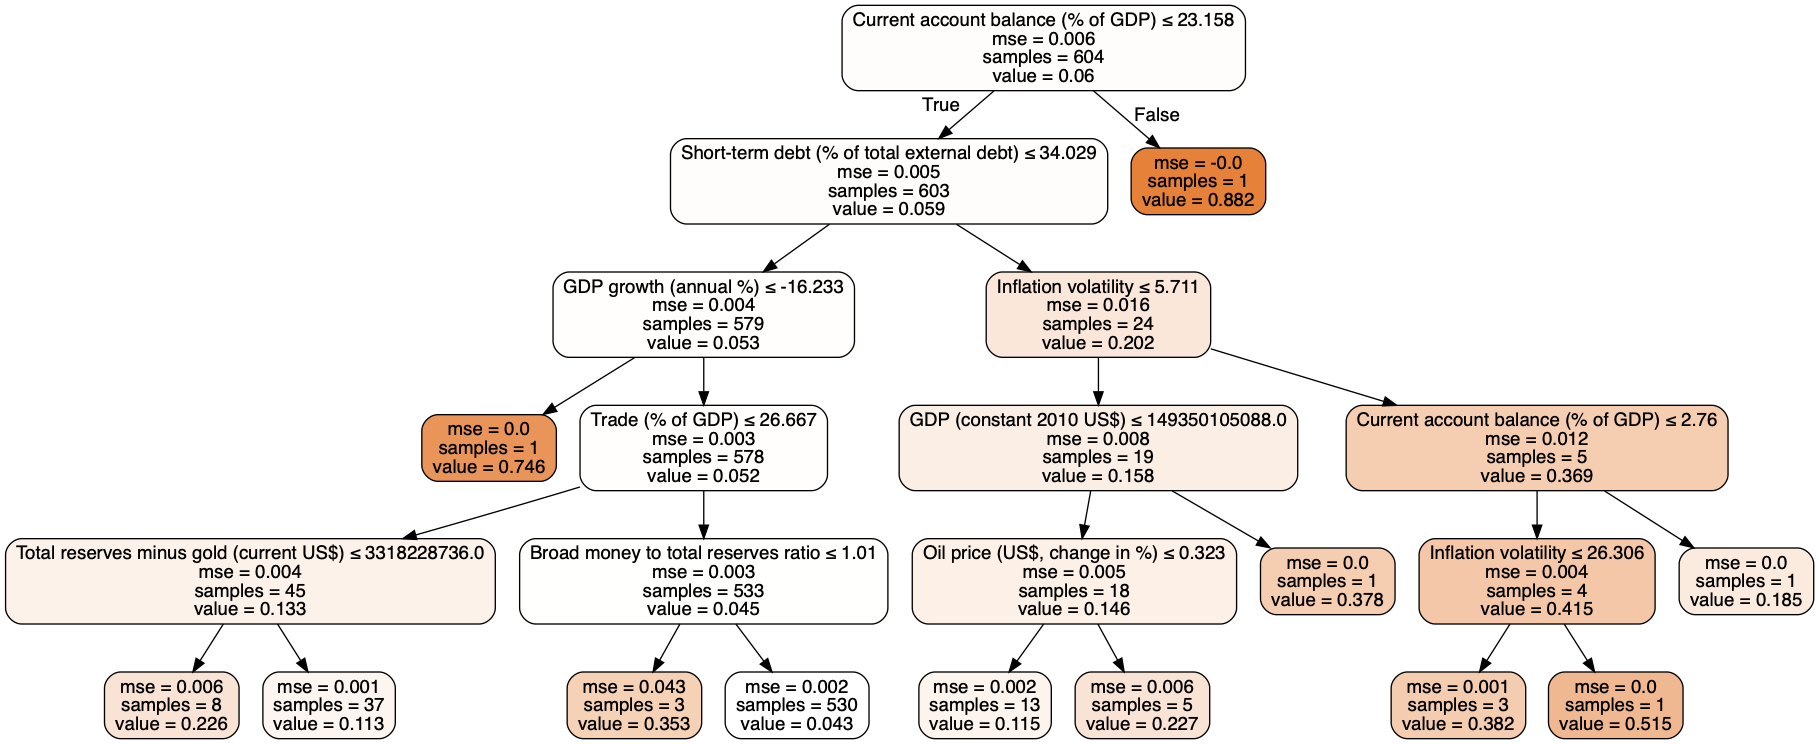

In [40]:
import sys
from IPython.display import Image
Image(filename=os.path.join(sys.path[0], "model.png"), width = 1000, height = 1000)

<a name="conclusion"></a>
## Conclusion 
What did we learn: 
- what classficiation problems are
- how decision trees work
- how we can create one sophisticated decision tree